<h1 align="center">Facial Recognition</h1>

    <Name> Jacob Barazoto
    <Date> 11/30/18

In [1]:
import os
import numpy as np
from imageio import imread
from matplotlib import pyplot as plt
import scipy.linalg as la
import zipfile
%matplotlib inline

In [7]:
with zipfile.ZipFile("./faces94.zip", 'r') as zip_ref:
    zip_ref.extractall()

### Helper Functions

In [3]:
def get_faces(path="./faces94"):
    """Traverse the specified directory to obtain one image per subdirectory. 
    Flatten and convert each image to grayscale.
    
    Parameters:
        path (str): The directory containing the dataset of images.  
    
    Returns:
        ((mn,k) ndarray) An array containing one column vector per
            subdirectory. k is the number of people, and each original
            image is mxn.
    """
    # Traverse the directory and get one image per subdirectory.
    faces = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                # Load the image, convert it to grayscale,
                # and flatten it into a vector.
                faces.append(np.ravel(imread(dirpath+"/"+fname, as_gray=True)))
                break
    # Put all the face vectors column-wise into a matrix.
    return np.transpose(faces)


def sample_faces(k, path="./faces94"):
    """Generate k sample images from the given path.

    Parameters:
        n (int): The number of sample images to obtain. 
        path(str): The directory containing the dataset of images.  
    
    Yields:
        ((mn,) ndarray): An flattend mn-array representing a single
        image. k images are yielded in total.
    """
    files = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                files.append(dirpath+"/"+fname)

    # Get a subset of the image names and yield the images one at a time.
    test_files = np.random.choice(files, k, replace=False)
    for fname in test_files:
        yield np.ravel(imread(fname, as_gray=True))

def show(image, m=200, n=180):
    """Plot the flattened grayscale 'image' of width 'w' and height 'h'.
    
    Parameters:
        image ((mn,) ndarray): A flattened image.
        m (int): The original number of rows in the image.
        n (int): The original number of columns in the image.
    """
    image = np.reshape(image,(m,n)) # reshapes to m x n matrix (200 x 180 in this case)
    data = plt.imshow(image,cmap='gray') # shows gray-scale image from m x n matrix
    plt.show()
    return  

### Class For Facial Recognition

In [6]:
class FacialRec(object):
    """
    Class for storing a database of face images, with methods for
    matching other faces to the database.
    
    Attributes:
        F ((mn,k) ndarray): The flatten images of the dataset, where
            k is the number of people, and each original image is mxn.
        mu ((mn,) ndarray): The mean of all flatten images.
        Fbar ((mn,k) ndarray): The images shifted by the mean.
        U ((mn,k) ndarray): The U in the compact SVD of Fbar;
            the columns are the eigenfaces.
    """
    def __init__(self, path='./faces94'):
        """
        Initialize the F, mu, Fbar, and U attributes.
        """
        # matrix of faces (mn x k)
        self.F = get_faces(path)
        # the mean face
        self.mu = np.mean(self.F, axis=1)
        # mean shifted faces to accentuate important features
        self.Fbar = self.F - np.vstack(self.mu)
        
        # SVD decomp of our mean-shifted faces
        # set U as matrix with columns as the eigenfaces (i.e. basis eigenvectors of mean-shifted faces)
        self.U,v,d = la.svd(self.Fbar, full_matrices=False)

    def project(self, A, s):
        """Project a face vector onto the subspace spanned by the first s
        eigenfaces, and represent that projection in terms of those eigenfaces.
            ****
            Note:
                As long as 's' isn't TOO small, the approximation of the faces
                will still be good enough for the algorithm to work well.
            ****
        
        Parameters:
            A((mn,) or (mn,l) ndarray): The array to be projected. 
            s(int): the number of eigenfaces.
        Returns: 
            ((s,) ndarray): An array of the projected image of s eigenfaces.
        """
        try:
            mn,l = A.shape    
        except:
            mn, = A.shape
        finally:
            if s >= mn:
                raise ValueError("You must choose an 's' such that s < mn. However:",s,">=",mn)
        # project our faces matrix F onto the first 's' eigenfaces (first 's' columns of self.U)
        # computationally less expensive with little accuracy lost
        return self.U[:,:s].T @ A

    def find_nearest(self, g, s=38):
        """Find the index j such that the jth column of F is the face that is
        closest to the face image 'g'.
        
        Parameters:
            g ((mn,) ndarray): A flattened face image.
            s (int): the number of eigenfaces to use in the projection.

        Returns:
            (int): the index of the column of F that is the best match to
                   the input face image 'g'.
        """
        # mean-shifted, projected database of faces
        Fhat = self.project(self.Fbar, s)
        # get mean-shifted, projected face we're comparing to our database
        ghat = self.project(g-self.mu, s)
        # gets the f_i \in F that is closest to our ghat by finding the smallest 2-norm
        # between f_i and ghat
        # return the index
        return np.argmin(np.linalg.norm(Fhat - np.vstack(ghat), axis=0))

    def match(self, image, s=38, m=200, n=180):
        """Display an image along with its closest match from the dataset. 
        
        Parameters:
            image ((mn,) ndarray): A flattened face image.
            s (int): The number of eigenfaces to use in the projection.
            m (int): The original number of rows in the image.
            n (int): The original number of columns in the image.
        """
        # finds most similar image in database
        j = self.find_nearest(image, s)
        match = self.F[:,j]
        # plot our image we're testing
        plt.subplot(121)
        plt.title("Input Image")
        show(image, m, n)
        # plot image that is most similar to ours
        plt.subplot(122)
        plt.title("Closest Match")
        show(match, m, n)
        
        plt.show()

### Testing Shifts

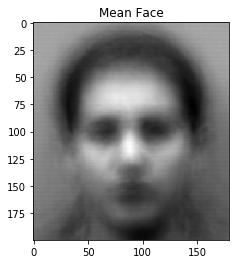

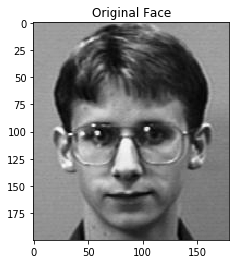

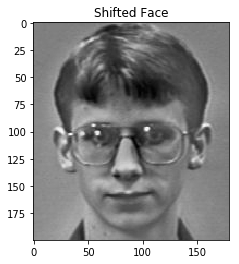

In [8]:
f = FacialRec() # initializes object
face = next(sample_faces(1)) # gets random face
shift = face - f.mu # gets shift of random face 

plt.title('Mean Face')
show(f.mu) # plots mean face

plt.title('Original Face')
show(face) # plots original (random) face

plt.title('Shifted Face')
show(shift) # plots the shift of the original (random) face

### Testing SVDs and Eigenfaces


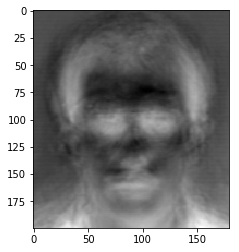

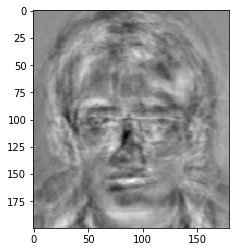

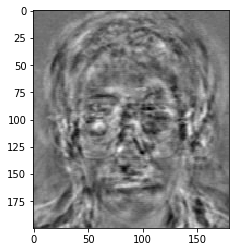

In [9]:
for i in [0,50,100]:
    show(f.U[:,i]) # 1st, 50th, and 100th eigenfaces (as shown in figure 7.2)

### Testing Projections Onto Smaller Subsets

Basically, the bigger the s-value we input, the more accurate our approximation will be.

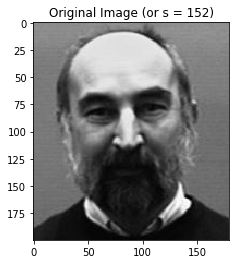

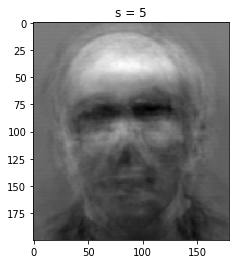

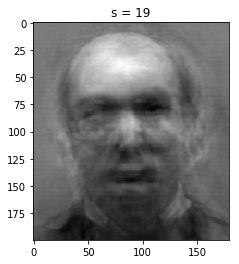

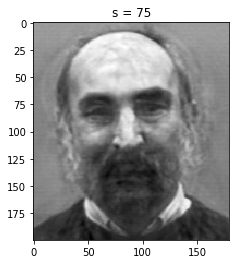

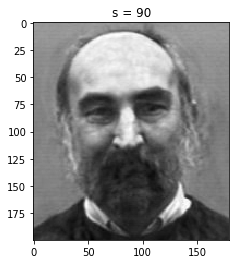

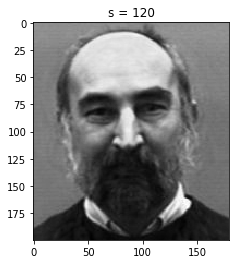

In [19]:
# fi_tild = U_s * fi_bar + µ ≈ fi
# fi_bar --> shifted image from F_bar
# µ --> mean
# U_s --> first 's' columns of U

index = 12 # we chose this shifted image for no particular reason
s = [5,19,75,90,120] # test values for s
f2 = FacialRec() # initializes new object
sProjFiBar = []
originalImage = f2.F[:,index]
fi_bar = f2.Fbar[:,index]

for i in s:
    sProjFiBar.append(f2.project(fi_bar,i)) # stores projections for each 's' value
    
plt.title('Original Image (or s = {})'.format(f.F.shape[1]-1))
show(originalImage)
for i in range(len(sProjFiBar)):
    recons = (f.U[:,:s[i]] @ sProjFiBar[i]) + f2.mu
    title = 's = '+str(s[i])
    plt.title(title)
    show(recons)



### Testing Finding Most Similar Face

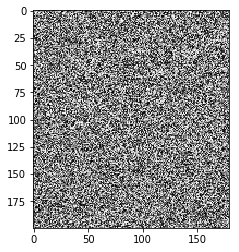

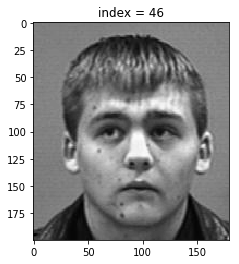

In [28]:
# generate random "photo" to test similarities
# changing bounds from 0-255 to something else under 255 will produce different results
g = np.random.randint(0,255,200*180)
similarIndex = f2.find_nearest(g,100) # implemented
show(g)

plt.title('index = {}'.format(str(similarIndex)))
# plots most similar image
show(f.F[:,similarIndex]) # at s = 38  --> index = 46 or 61
                          # at s = 19  --> index = 50
                          # at s = 1   --> index = 74, 107, 119, or 131
                          # at s = 153 --> index = 46

### Testing Matching Faces with Most Similar

Seems to work well.

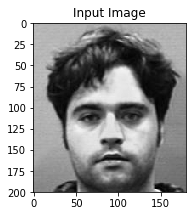

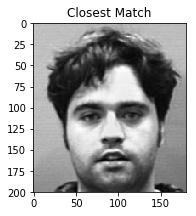

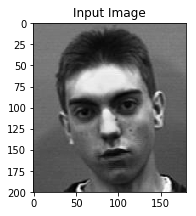

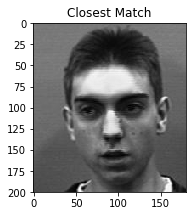

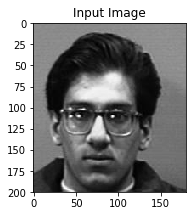

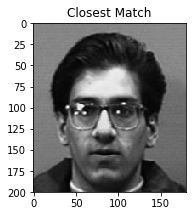

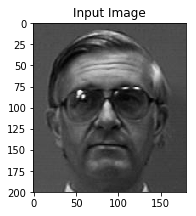

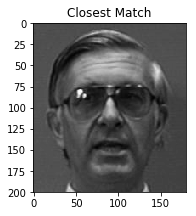

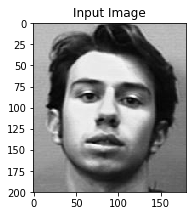

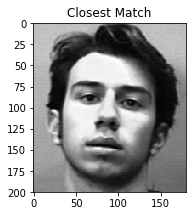

In [35]:
f = FacialRec() # initializes object
s = 38
face = next(sample_faces(1)) # gets random face
for test_image in sample_faces(5):
    f.match(test_image)

